# Portfolios Example

In [1]:
%matplotlib notebook
import numpy as np
import pickle
from multiplicative_weigths import Multiplicative_Weights
import warnings
import time
from factors import Factor

Pre-process (Run only once)

In [2]:
#load objects
prices=pickle.load(open('Q://LB2//dump//prices.p', 'rb'))
prices=prices.reindex_axis(sorted(prices.columns), axis=1)
returns=Factor.prices_to_returns(prices, replace_missing=True)

### MWU algorithm

In [12]:
start = time.time()
params={'rebalance_window':1,
        'rebalance_period':'monthly',
        'cost':40,
        'eta':10.0,
        'beta':1.0
        }
algorithm = Multiplicative_Weights(params)
algorithm.add_filter('Q://Fatores//filter//IBOV.csv')
result_mwu = algorithm.run(returns,start_date='2011-01-01',end_date='2018-03-18',show_progress_bar=True)
end = time.time()
print('MWU Elapsed time: ', (end-start), ' segundos')


MWU Elapsed time:  16.64645767211914  segundos


Summary:
        Yrly ROA: 0.12
        R2: 0.17
        Yrly Sharpe Ratio: 0.35
        Annualized return: 5.37%
        Annualized volatility: 21.50%
        Longest drawdown: 855 days
        Net Return: 45.34%
        Yrly Turnover: 51.58%
        Winning days: 50.7%
        Start Date: 01/2011
        End Date: 03/2018
        


C:\Users\ckubudi\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\ckubudi\Documents\olps-mestrado\algorithm_result.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[column]=df[column].cumprod()


<IPython.core.display.Javascript object>


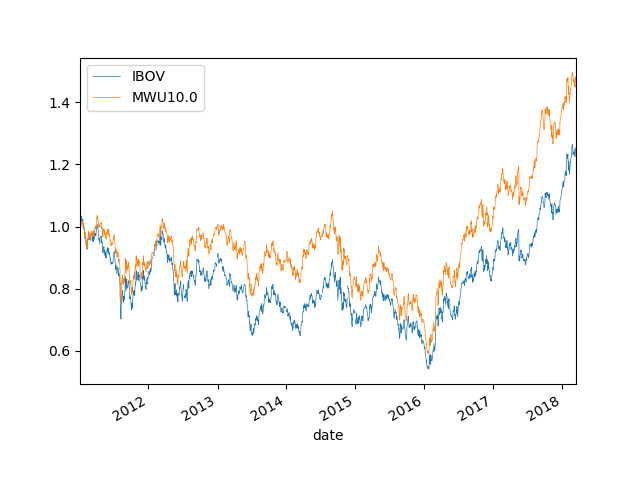

<IPython.core.display.Javascript object>


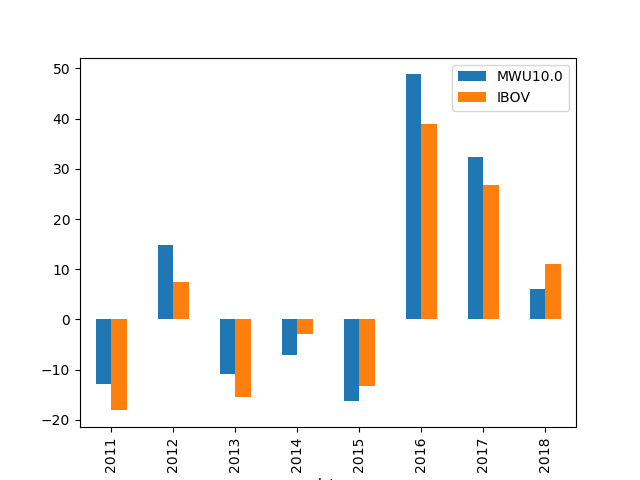

In [13]:
result_mwu.add_benchmark('Q:///LB2//benchmark//IBOV.csv')
print(result_mwu.summary())
result_mwu.plot()
result_mwu.plot_yrly_result()

In [14]:
result_mwu.weights.to_csv("Z:/weights_eta10_1.csv")

In [ ]:
result_mwu.add_benchmark('../data/benchmark/IBOV.csv')
result_mwu.add_benchmark('../data/benchmark/DynamoCougar.csv')
result_mwu.plot()
result_mwu.plot_yrly_result()

### Pattern Matching algorithm

In [ ]:
start = time.time()
algorithm = Pattern_Matching(window_size=22,c_threshold=0.6)
algorithm.rebalance_window=1
algorithm.rebalance_period='monthly'
algorithm.cost=.004
result_pm = algorithm.run(returns,start_date='01/01/2006')
end = time.time()
print('Pattern Matching Elapsed time: ', (end-start), ' segundos')
print(result_pm.summary())

### Join results

In [ ]:
res_list=[result_momentum,result_vol,result_mwu,result_pm]

In [ ]:
results = AlgorithmResultsList(res_list)
results.add_benchmark('../data/benchmark/IBOV.csv')
results.plot()

In [ ]:
hedged_res_list=[]
for result in res_list:
    temp=result.get_hedged_result('../data/benchmark/IBOV.csv',0.5)
    hedged_res_list.append(temp)
results = AlgorithmResultsList(hedged_res_list)
results.plot()